# Combined Location Analysis

This notebook combines locations by summing QTY and averaging other features, then trains models on both the combined dataset and individual location datasets to compare different data aggregation strategies.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Traditional ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Nixtla client for TimeGPT
from nixtla import NixtlaClient

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the consolidated data
df = pd.read_csv('../outputs/data/sales_weather_merged_filled_consolidated.csv')
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Locations: {df['Location'].unique()}")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Location', 'date']).reset_index(drop=True)

# Display basic statistics
print(f"\nBasic Statistics:")
print(f"Total records: {len(df)}")
print(f"Records per location:")
for location in df['Location'].unique():
    count = len(df[df['Location'] == location])
    print(f"  {location}: {count} records")

df.head()


Data shape: (286, 18)
Date range: 2019-04-01 to 2024-03-01
Locations: ['Bangalore' 'Chennai' 'Cochin' 'Secunderabad' 'Vijaywada' 'Sricity']

Basic Statistics:
Total records: 286
Records per location:
  Bangalore: 59 records
  Chennai: 59 records
  Cochin: 59 records
  Secunderabad: 59 records
  Sricity: 8 records
  Vijaywada: 42 records


,Location,QTY,temp_min,temp_max,temp_mean,dwpt_min,dwpt_max,dwpt_mean,rhum_min,rhum_max,rhum_mean,prcp_min,prcp_max,prcp_mean,wspd_min,wspd_max,wspd_mean,date
0,Bangalore,1678.0,15.0,34.40,25.490457,-2.240,21.820,12.241344,11.20,99.6,49.995161,0.0,1.875000,0.009845,1.08,34.480,10.858306,2019-04-01
1,Bangalore,3951.0,19.0,35.25,27.041071,0.775,23.275,15.193029,12.25,100.0,54.193651,0.0,7.766667,0.056111,0.00,36.625,10.347719,2019-05-01
2,Bangalore,4709.0,19.6,34.40,26.270377,10.240,24.420,19.395948,24.80,100.0,69.900511,0.0,8.166667,0.159319,0.00,38.960,13.101580,2019-06-01
3,Bangalore,2418.0,19.6,32.40,24.810296,14.280,24.020,19.992738,38.00,100.0,76.857086,0.0,7.800000,0.155787,1.44,41.540,17.832391,2019-07-01
4,Bangalore,2252.0,19.6,30.40,23.654283,16.740,23.260,20.154345,45.40,100.0,82.423583,0.0,7.633333,0.201703,1.44,41.600,18.792103,2019-08-01


In [3]:
# Create combined dataset by aggregating locations
def create_combined_dataset(df):
    """
    Combine all locations by summing QTY and averaging other features
    """
    print("Creating combined dataset...")
    
    # Group by date and aggregate
    combined_df = df.groupby('date').agg({
        'QTY': 'sum',  # Sum QTY across all locations
        'temp_mean': 'mean',  # Average temperature
        'temp_max': 'mean',   # Average max temperature
        'temp_min': 'mean',   # Average min temperature
        'rhum_mean': 'mean',  # Average humidity
        'wspd_mean': 'mean',  # Average wind speed
        'prcp_mean': 'mean',  # Average precipitation
        'Location': 'count'   # Count of locations (for reference)
    }).reset_index()
    
    # Rename the count column
    combined_df = combined_df.rename(columns={'Location': 'location_count'})
    
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
    print(f"Total QTY range: {combined_df['QTY'].min():.0f} to {combined_df['QTY'].max():.0f}")
    
    return combined_df

# Create the combined dataset
combined_df = create_combined_dataset(df)
combined_df.head()


Creating combined dataset...
Combined dataset shape: (59, 9)
Date range: 2019-04-01 00:00:00 to 2024-03-01 00:00:00
Total QTY range: 6859 to 148198


,date,QTY,temp_mean,temp_max,temp_min,rhum_mean,wspd_mean,prcp_mean,location_count
0,2019-04-01,24898.0,27.795799,36.550000,19.50500,61.887679,9.561976,0.034400,4
1,2019-05-01,49432.0,29.128674,37.641667,21.96250,64.622989,9.882263,0.103160,4
2,2019-06-01,62585.0,29.419473,37.647500,22.46500,69.518355,11.112703,0.216445,4
3,2019-07-01,26843.0,28.207251,36.285000,22.36375,74.852935,13.068283,0.242812,4
4,2019-08-01,18577.0,26.561297,33.465000,22.06000,81.953193,13.350484,0.359022,4


In [4]:
# Import helper functions from previous notebooks
def create_time_features(df):
    """
    Create comprehensive time-based features for forecasting
    """
    df = df.copy()
    
    # Extract temporal indicators
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Cyclical encoding for seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    # Weather interaction features
    if 'temp_mean' in df.columns and 'rhum_mean' in df.columns:
        df['temp_humidity_interaction'] = df['temp_mean'] * df['rhum_mean']
    if 'temp_mean' in df.columns and 'wspd_mean' in df.columns:
        df['temp_wind_interaction'] = df['temp_mean'] * df['wspd_mean']
    
    return df

def create_lag_and_rolling_features(df, target_col='QTY', lags=[1, 2, 3, 6, 12], windows=[3, 6, 12]):
    """
    Create lag and rolling features to prevent data leakage
    """
    df = df.copy()
    
    # Create lag features (only using past data)
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Create rolling statistics (only using past data)
    for window in windows:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean().shift(1)
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1)
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min().shift(1)
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max().shift(1)
    
    return df

def prepare_data_for_modeling(df, test_months=12):
    """
    Prepare data for modeling with train/test split
    """
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    # Create time features
    df = create_time_features(df)
    
    # Create lag and rolling features
    df = create_lag_and_rolling_features(df)
    
    # Split data: last test_months for testing
    split_idx = len(df) - test_months
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    
    # Remove rows with NaN from lag/rolling features in training set
    train_df = train_df.dropna().reset_index(drop=True)
    
    # Check if we have any training data left
    if len(train_df) == 0:
        print("Warning: No valid training data after feature engineering. Skipping.")
        return None
    
    # Define feature columns (exclude target and non-feature columns)
    exclude_cols = ['QTY', 'date', 'Location']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Prepare features and target
    X_train = train_df[feature_cols].fillna(0)  # Fill any remaining NaN with 0
    y_train = train_df['QTY']
    X_test = test_df[feature_cols].fillna(0)
    y_test = test_df['QTY']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train.values,
        'y_test': y_test.values,
        'train_df': train_df,
        'test_df': test_df,
        'feature_cols': feature_cols,
        'scaler': scaler
    }

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

print("Helper functions loaded successfully!")


Helper functions loaded successfully!


In [5]:
# Define model training functions
def create_ml_models():
    """Create a collection of ML models"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1),
        'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=False),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }
    return models

def train_ml_models(X_train, y_train, X_test, y_test):
    """Train all ML models and return predictions"""
    models = create_ml_models()
    results = {}
    
    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)
            results[name] = {
                'model': model,
                'predictions': y_pred,
                'metrics': metrics
            }
            
            print(f"✓ {name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
            
        except Exception as e:
            print(f"✗ {name}: Failed - {str(e)}")
    
    return results

def train_arima_model(train_df, test_df):
    """Train ARIMA model"""
    try:
        # Fit ARIMA model
        model = ARIMA(train_df['QTY'], order=(1, 1, 1))
        fitted_model = model.fit()
        
        # Make predictions
        predictions = fitted_model.forecast(steps=len(test_df))
        
        # Calculate metrics
        metrics = calculate_metrics(test_df['QTY'], predictions)
        
        print(f"✓ ARIMA: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
        
        return {
            'model': fitted_model,
            'predictions': predictions,
            'metrics': metrics
        }
        
    except Exception as e:
        print(f"✗ ARIMA: Failed - {str(e)}")
        return None

def train_sarima_model(train_df, test_df):
    """Train SARIMA model"""
    try:
        # Fit SARIMA model
        model = SARIMAX(train_df['QTY'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fitted_model = model.fit(disp=False)
        
        # Make predictions
        predictions = fitted_model.forecast(steps=len(test_df))
        
        # Calculate metrics
        metrics = calculate_metrics(test_df['QTY'], predictions)
        
        print(f"✓ SARIMA: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
        
        return {
            'model': fitted_model,
            'predictions': predictions,
            'metrics': metrics
        }
        
    except Exception as e:
        print(f"✗ SARIMA: Failed - {str(e)}")
        return None

def train_prophet_model(train_df, test_df):
    """Train Prophet model"""
    try:
        # Prepare data for Prophet
        prophet_train = train_df[['date', 'QTY']].copy()
        prophet_train.columns = ['ds', 'y']
        
        # Fit Prophet model
        model = Prophet()
        model.fit(prophet_train)
        
        # Make predictions
        future = model.make_future_dataframe(periods=len(test_df))
        forecast = model.predict(future)
        predictions = forecast['yhat'].iloc[-len(test_df):].values
        
        # Calculate metrics
        metrics = calculate_metrics(test_df['QTY'], predictions)
        
        print(f"✓ Prophet: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
        
        return {
            'model': model,
            'predictions': predictions,
            'metrics': metrics
        }
        
    except Exception as e:
        print(f"✗ Prophet: Failed - {str(e)}")
        return None

def train_ets_model(train_df, test_df):
    """Train ETS model"""
    try:
        # Fit ETS model
        if len(train_df) < 24:
            # Use simple exponential smoothing if insufficient data
            model = ExponentialSmoothing(train_df['QTY'], seasonal=None)
        else:
            # Use seasonal Holt-Winters
            model = ExponentialSmoothing(train_df['QTY'], seasonal='add', seasonal_periods=12)
        
        fitted_model = model.fit()
        
        # Make predictions
        predictions = fitted_model.forecast(steps=len(test_df))
        
        # Calculate metrics
        metrics = calculate_metrics(test_df['QTY'], predictions)
        
        print(f"✓ ETS: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
        
        return {
            'model': fitted_model,
            'predictions': predictions,
            'metrics': metrics
        }
        
    except Exception as e:
        print(f"✗ ETS: Failed - {str(e)}")
        return None

def train_timegpt_model(train_df, test_df):
    """Train TimeGPT model"""
    try:
        # Initialize Nixtla client
        client = NixtlaClient()
        
        # Prepare data for TimeGPT
        timegpt_train = train_df[['date', 'QTY']].copy()
        timegpt_train.columns = ['ds', 'y']
        timegpt_train['ds'] = pd.to_datetime(timegpt_train['ds'])
        timegpt_train = timegpt_train.set_index('ds').resample('MS').first().reset_index()
        timegpt_train = timegpt_train.dropna()
        
        if len(timegpt_train) < 12:
            print("✗ TimeGPT: Insufficient data")
            return None
        
        # Make predictions
        predictions = client.forecast(
            df=timegpt_train,
            h=len(test_df),
            freq='MS'
        )
        
        # Calculate metrics
        metrics = calculate_metrics(test_df['QTY'], predictions['TimeGPT'])
        
        print(f"✓ TimeGPT: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
        
        return {
            'model': client,
            'predictions': predictions['TimeGPT'].values,
            'metrics': metrics
        }
        
    except Exception as e:
        print(f"✗ TimeGPT: Failed - {str(e)}")
        return None

print("Model training functions defined successfully!")


Model training functions defined successfully!


In [6]:
# Train models on combined dataset
print("="*80)
print("TRAINING MODELS ON COMBINED DATASET")
print("="*80)

# Prepare combined data
combined_data = prepare_data_for_modeling(combined_df)

if combined_data is None:
    print("Failed to prepare combined data")
else:
    print(f"Combined dataset - Training samples: {len(combined_data['y_train'])}")
    print(f"Combined dataset - Test samples: {len(combined_data['y_test'])}")
    
    # Initialize results storage
    combined_results = []
    
    # Train ML models
    print("\n--- Training ML Models on Combined Dataset ---")
    ml_results = train_ml_models(
        combined_data['X_train'],
        combined_data['y_train'],
        combined_data['X_test'],
        combined_data['y_test']
    )
    
    # Store ML results
    for name, result in ml_results.items():
        combined_results.append({
            'Dataset': 'Combined',
            'Model_Type': 'ML',
            'Model_Name': name,
            'MAE': result['metrics']['MAE'],
            'RMSE': result['metrics']['RMSE'],
            'MAPE': result['metrics']['MAPE'],
            'R2': result['metrics']['R2']
        })
    
    # Train Time Series models
    print("\n--- Training Time Series Models on Combined Dataset ---")
    
    # ARIMA
    arima_result = train_arima_model(combined_data['train_df'], combined_data['test_df'])
    if arima_result:
        combined_results.append({
            'Dataset': 'Combined',
            'Model_Type': 'Time Series',
            'Model_Name': 'ARIMA',
            'MAE': arima_result['metrics']['MAE'],
            'RMSE': arima_result['metrics']['RMSE'],
            'MAPE': arima_result['metrics']['MAPE'],
            'R2': arima_result['metrics']['R2']
        })
    
    # SARIMA
    sarima_result = train_sarima_model(combined_data['train_df'], combined_data['test_df'])
    if sarima_result:
        combined_results.append({
            'Dataset': 'Combined',
            'Model_Type': 'Time Series',
            'Model_Name': 'SARIMA',
            'MAE': sarima_result['metrics']['MAE'],
            'RMSE': sarima_result['metrics']['RMSE'],
            'MAPE': sarima_result['metrics']['MAPE'],
            'R2': sarima_result['metrics']['R2']
        })
    
    # Prophet
    prophet_result = train_prophet_model(combined_data['train_df'], combined_data['test_df'])
    if prophet_result:
        combined_results.append({
            'Dataset': 'Combined',
            'Model_Type': 'Time Series',
            'Model_Name': 'Prophet',
            'MAE': prophet_result['metrics']['MAE'],
            'RMSE': prophet_result['metrics']['RMSE'],
            'MAPE': prophet_result['metrics']['MAPE'],
            'R2': prophet_result['metrics']['R2']
        })
    
    # ETS
    ets_result = train_ets_model(combined_data['train_df'], combined_data['test_df'])
    if ets_result:
        combined_results.append({
            'Dataset': 'Combined',
            'Model_Type': 'Time Series',
            'Model_Name': 'ETS',
            'MAE': ets_result['metrics']['MAE'],
            'RMSE': ets_result['metrics']['RMSE'],
            'MAPE': ets_result['metrics']['MAPE'],
            'R2': ets_result['metrics']['R2']
        })
    
    # TimeGPT
    timegpt_result = train_timegpt_model(combined_data['train_df'], combined_data['test_df'])
    if timegpt_result:
        combined_results.append({
            'Dataset': 'Combined',
            'Model_Type': 'Time Series',
            'Model_Name': 'TimeGPT',
            'MAE': timegpt_result['metrics']['MAE'],
            'RMSE': timegpt_result['metrics']['RMSE'],
            'MAPE': timegpt_result['metrics']['MAPE'],
            'R2': timegpt_result['metrics']['R2']
        })
    
    print(f"\nCombined dataset analysis completed!")
    print(f"Total models trained: {len(combined_results)}")


TRAINING MODELS ON COMBINED DATASET
Combined dataset - Training samples: 35
Combined dataset - Test samples: 12

--- Training ML Models on Combined Dataset ---
✓ Linear Regression: MAE=701446.45, RMSE=862439.90, R²=-652.642
✓ Ridge: MAE=138022.28, RMSE=140254.58, R²=-16.287
✓ Lasso: MAE=273627.31, RMSE=280696.62, R²=-68.240
✓ ElasticNet: MAE=106943.36, RMSE=108480.99, R²=-9.342
✓ Random Forest: MAE=22656.31, RMSE=31916.95, R²=0.105
✓ Gradient Boosting: MAE=24326.32, RMSE=33701.31, R²=0.002
✓ AdaBoost: MAE=25173.49, RMSE=33446.56, R²=0.017
✓ Extra Trees: MAE=24860.27, RMSE=33868.02, R²=-0.008
✓ XGBoost: MAE=28054.95, RMSE=35982.77, R²=-0.138
✓ LightGBM: MAE=28360.23, RMSE=42906.20, R²=-0.618
✓ CatBoost: MAE=25900.54, RMSE=34576.02, R²=-0.051
✓ SVR: MAE=33881.18, RMSE=47287.63, R²=-0.965
✓ KNN: MAE=30164.10, RMSE=38078.47, R²=-0.274

--- Training Time Series Models on Combined Dataset ---
✓ ARIMA: MAE=27795.73, RMSE=41899.94, R²=-0.543
✓ SARIMA: MAE=15695.40, RMSE=26859.50, R²=0.366


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


✓ Prophet: MAE=64957.81, RMSE=71275.76, R²=-3.464
✓ ETS: MAE=25548.10, RMSE=32844.99, R²=0.052
✗ TimeGPT: Failed - 'NIXTLA_API_KEY'

Combined dataset analysis completed!
Total models trained: 17


In [7]:
# Train models on individual locations
print("\n" + "="*80)
print("TRAINING MODELS ON INDIVIDUAL LOCATIONS")
print("="*80)

# Get all locations
all_locations = df['Location'].unique()
print(f"Locations to analyze: {all_locations}")

# Initialize results storage
individual_results = []

# Analyze each location
for location in all_locations:
    print(f"\n{'='*60}")
    print(f"Analyzing Location: {location}")
    print(f"{'='*60}")
    
    # Filter data for specific location
    location_df = df[df['Location'] == location].copy()
    
    # Prepare data for location
    location_data = prepare_data_for_modeling(location_df)
    
    if location_data is None:
        print(f"Skipping {location} - insufficient data")
        continue
    
    print(f"Training samples: {len(location_data['y_train'])}")
    print(f"Test samples: {len(location_data['y_test'])}")
    
    # Train ML models
    print("\n--- Training ML Models ---")
    ml_results = train_ml_models(
        location_data['X_train'],
        location_data['y_train'],
        location_data['X_test'],
        location_data['y_test']
    )
    
    # Store ML results
    for name, result in ml_results.items():
        individual_results.append({
            'Dataset': location,
            'Model_Type': 'ML',
            'Model_Name': name,
            'MAE': result['metrics']['MAE'],
            'RMSE': result['metrics']['RMSE'],
            'MAPE': result['metrics']['MAPE'],
            'R2': result['metrics']['R2']
        })
    
    # Train Time Series models
    print("\n--- Training Time Series Models ---")
    
    # ARIMA
    arima_result = train_arima_model(location_data['train_df'], location_data['test_df'])
    if arima_result:
        individual_results.append({
            'Dataset': location,
            'Model_Type': 'Time Series',
            'Model_Name': 'ARIMA',
            'MAE': arima_result['metrics']['MAE'],
            'RMSE': arima_result['metrics']['RMSE'],
            'MAPE': arima_result['metrics']['MAPE'],
            'R2': arima_result['metrics']['R2']
        })
    
    # SARIMA
    sarima_result = train_sarima_model(location_data['train_df'], location_data['test_df'])
    if sarima_result:
        individual_results.append({
            'Dataset': location,
            'Model_Type': 'Time Series',
            'Model_Name': 'SARIMA',
            'MAE': sarima_result['metrics']['MAE'],
            'RMSE': sarima_result['metrics']['RMSE'],
            'MAPE': sarima_result['metrics']['MAPE'],
            'R2': sarima_result['metrics']['R2']
        })
    
    # Prophet
    prophet_result = train_prophet_model(location_data['train_df'], location_data['test_df'])
    if prophet_result:
        individual_results.append({
            'Dataset': location,
            'Model_Type': 'Time Series',
            'Model_Name': 'Prophet',
            'MAE': prophet_result['metrics']['MAE'],
            'RMSE': prophet_result['metrics']['RMSE'],
            'MAPE': prophet_result['metrics']['MAPE'],
            'R2': prophet_result['metrics']['R2']
        })
    
    # ETS
    ets_result = train_ets_model(location_data['train_df'], location_data['test_df'])
    if ets_result:
        individual_results.append({
            'Dataset': location,
            'Model_Type': 'Time Series',
            'Model_Name': 'ETS',
            'MAE': ets_result['metrics']['MAE'],
            'RMSE': ets_result['metrics']['RMSE'],
            'MAPE': ets_result['metrics']['MAPE'],
            'R2': ets_result['metrics']['R2']
        })
    
    # TimeGPT
    timegpt_result = train_timegpt_model(location_data['train_df'], location_data['test_df'])
    if timegpt_result:
        individual_results.append({
            'Dataset': location,
            'Model_Type': 'Time Series',
            'Model_Name': 'TimeGPT',
            'MAE': timegpt_result['metrics']['MAE'],
            'RMSE': timegpt_result['metrics']['RMSE'],
            'MAPE': timegpt_result['metrics']['MAPE'],
            'R2': timegpt_result['metrics']['R2']
        })
    
    print(f"✓ Completed {location}: {len(ml_results) + sum([1 for r in [arima_result, sarima_result, prophet_result, ets_result, timegpt_result] if r is not None])} models trained")

print(f"\n{'='*80}")
print(f"Individual location analysis completed!")
print(f"Total individual results: {len(individual_results)}")
print(f"{'='*80}")



TRAINING MODELS ON INDIVIDUAL LOCATIONS
Locations to analyze: ['Bangalore' 'Chennai' 'Cochin' 'Secunderabad' 'Sricity' 'Vijaywada']

Analyzing Location: Bangalore
Training samples: 35
Test samples: 12

--- Training ML Models ---
✓ Linear Regression: MAE=14860.14, RMSE=36129.59, R²=-214.797
✓ Ridge: MAE=2682.93, RMSE=3590.55, R²=-1.131
✓ Lasso: MAE=5004.74, RMSE=7063.42, R²=-7.248
✓ ElasticNet: MAE=2325.34, RMSE=3127.09, R²=-0.617
✓ Random Forest: MAE=1692.50, RMSE=2074.75, R²=0.288
✓ Gradient Boosting: MAE=1677.89, RMSE=2317.57, R²=0.112
✓ AdaBoost: MAE=1255.89, RMSE=1685.67, R²=0.530
✓ Extra Trees: MAE=1896.71, RMSE=2494.48, R²=-0.029
✓ XGBoost: MAE=1609.18, RMSE=2117.70, R²=0.259
✓ LightGBM: MAE=1958.58, RMSE=3020.98, R²=-0.509
✓ CatBoost: MAE=1532.17, RMSE=2158.91, R²=0.229
✓ SVR: MAE=2666.99, RMSE=3619.28, R²=-1.166
✓ KNN: MAE=1721.38, RMSE=2145.26, R²=0.239

--- Training Time Series Models ---
✓ ARIMA: MAE=1856.15, RMSE=2765.18, R²=-0.264


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing


✓ SARIMA: MAE=692.39, RMSE=1218.23, R²=0.755


INFO:cmdstanpy:Chain [1] done processing


✓ Prophet: MAE=6146.70, RMSE=6397.04, R²=-5.765
✓ ETS: MAE=1690.66, RMSE=1812.95, R²=0.457
✗ TimeGPT: Failed - 'NIXTLA_API_KEY'
✓ Completed Bangalore: 17 models trained

Analyzing Location: Chennai
Training samples: 35
Test samples: 12

--- Training ML Models ---
✓ Linear Regression: MAE=57683.29, RMSE=170509.53, R²=-903.133
✓ Ridge: MAE=7831.98, RMSE=8532.15, R²=-1.264
✓ Lasso: MAE=19759.15, RMSE=21051.40, R²=-12.782
✓ ElasticNet: MAE=5489.41, RMSE=6243.20, R²=-0.212
✓ Random Forest: MAE=4061.75, RMSE=4755.69, R²=0.297
✓ Gradient Boosting: MAE=5964.87, RMSE=6747.18, R²=-0.416
✓ AdaBoost: MAE=5104.51, RMSE=6264.54, R²=-0.220
✓ Extra Trees: MAE=4853.09, RMSE=5645.71, R²=0.009
✓ XGBoost: MAE=5794.46, RMSE=6612.90, R²=-0.360
✓ LightGBM: MAE=4870.79, RMSE=6474.34, R²=-0.304
✓ CatBoost: MAE=3442.15, RMSE=4382.76, R²=0.403
✓ SVR: MAE=5957.58, RMSE=7934.04, R²=-0.958
✓ KNN: MAE=3893.48, RMSE=4496.35, R²=0.371

--- Training Time Series Models ---
✓ ARIMA: MAE=4966.11, RMSE=6645.69, R²=-0.373


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing


✓ SARIMA: MAE=6291.24, RMSE=7511.02, R²=-0.754


INFO:cmdstanpy:Chain [1] done processing


✓ Prophet: MAE=70017.05, RMSE=80851.34, R²=-202.287
✓ ETS: MAE=3356.30, RMSE=4508.42, R²=0.368
✗ TimeGPT: Failed - 'NIXTLA_API_KEY'
✓ Completed Chennai: 17 models trained

Analyzing Location: Cochin
Training samples: 35
Test samples: 12

--- Training ML Models ---
✓ Linear Regression: MAE=7265.34, RMSE=9653.54, R²=-5.202
✓ Ridge: MAE=4150.04, RMSE=4636.34, R²=-0.430
✓ Lasso: MAE=5033.39, RMSE=6166.11, R²=-1.530
✓ ElasticNet: MAE=3910.23, RMSE=4456.21, R²=-0.321
✓ Random Forest: MAE=3306.09, RMSE=4180.62, R²=-0.163
✓ Gradient Boosting: MAE=3673.31, RMSE=4663.37, R²=-0.447
✓ AdaBoost: MAE=3246.90, RMSE=3960.00, R²=-0.044
✓ Extra Trees: MAE=2911.54, RMSE=3687.01, R²=0.095
✓ XGBoost: MAE=3648.53, RMSE=4441.98, R²=-0.313
✓ LightGBM: MAE=3784.35, RMSE=5194.87, R²=-0.796
✓ CatBoost: MAE=3546.67, RMSE=4440.97, R²=-0.312
✓ SVR: MAE=4153.15, RMSE=5578.06, R²=-1.071
✓ KNN: MAE=3393.23, RMSE=4344.67, R²=-0.256

--- Training Time Series Models ---
✓ ARIMA: MAE=3822.22, RMSE=5214.62, R²=-0.810


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing


✓ SARIMA: MAE=2993.84, RMSE=3880.94, R²=-0.002


INFO:cmdstanpy:Chain [1] done processing


✓ Prophet: MAE=3019.34, RMSE=4102.90, R²=-0.120
✓ ETS: MAE=3327.39, RMSE=3995.47, R²=-0.062
✗ TimeGPT: Failed - 'NIXTLA_API_KEY'
✓ Completed Cochin: 17 models trained

Analyzing Location: Secunderabad
Training samples: 35
Test samples: 12

--- Training ML Models ---
✓ Linear Regression: MAE=48773.99, RMSE=129418.71, R²=-196.709
✓ Ridge: MAE=6081.55, RMSE=9143.05, R²=0.013
✓ Lasso: MAE=6085.01, RMSE=9586.49, R²=-0.085
✓ ElasticNet: MAE=5866.44, RMSE=9024.98, R²=0.039
✓ Random Forest: MAE=5269.54, RMSE=7984.14, R²=0.248
✓ Gradient Boosting: MAE=4672.80, RMSE=7899.09, R²=0.263
✓ AdaBoost: MAE=5514.57, RMSE=8265.84, R²=0.193
✓ Extra Trees: MAE=5336.78, RMSE=8121.80, R²=0.221
✓ XGBoost: MAE=5456.77, RMSE=8271.87, R²=0.192
✓ LightGBM: MAE=6464.74, RMSE=10675.98, R²=-0.345
✓ CatBoost: MAE=5356.62, RMSE=8254.89, R²=0.196
✓ SVR: MAE=8055.89, RMSE=11880.80, R²=-0.666
✓ KNN: MAE=5897.03, RMSE=9201.16, R²=0.001

--- Training Time Series Models ---
✓ ARIMA: MAE=6489.00, RMSE=10449.91, R²=-0.289


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing


✓ SARIMA: MAE=4672.99, RMSE=7630.03, R²=0.313


INFO:cmdstanpy:Chain [1] done processing


✓ Prophet: MAE=19894.65, RMSE=22052.95, R²=-4.741
✓ ETS: MAE=5706.84, RMSE=8329.20, R²=0.181
✗ TimeGPT: Failed - 'NIXTLA_API_KEY'
✓ Completed Secunderabad: 17 models trained

Analyzing Location: Sricity
Skipping Sricity - insufficient data

Analyzing Location: Vijaywada
Training samples: 18
Test samples: 12

--- Training ML Models ---
✓ Linear Regression: MAE=6528.31, RMSE=8178.90, R²=-3.581
✓ Ridge: MAE=4395.58, RMSE=5154.27, R²=-0.819
✓ Lasso: MAE=6629.43, RMSE=8598.78, R²=-4.063
✓ ElasticNet: MAE=4453.55, RMSE=5203.81, R²=-0.854
✓ Random Forest: MAE=3651.38, RMSE=4396.99, R²=-0.324
✓ Gradient Boosting: MAE=3810.40, RMSE=4431.69, R²=-0.345
✓ AdaBoost: MAE=3926.08, RMSE=4622.80, R²=-0.463
✓ Extra Trees: MAE=3841.73, RMSE=4568.78, R²=-0.429
✓ XGBoost: MAE=3983.33, RMSE=4637.49, R²=-0.473
✓ LightGBM: MAE=4000.61, RMSE=5143.00, R²=-0.811
✓ CatBoost: MAE=3873.11, RMSE=4614.70, R²=-0.458
✓ SVR: MAE=4517.42, RMSE=5691.07, R²=-1.218
✓ KNN: MAE=3531.90, RMSE=4464.90, R²=-0.365

--- Training T

e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


✓ SARIMA: MAE=2788.55, RMSE=3535.57, R²=0.144
✓ Prophet: MAE=3955.34, RMSE=5097.85, R²=-0.780
✓ ETS: MAE=3408.07, RMSE=4249.47, R²=-0.237
✗ TimeGPT: Failed - 'NIXTLA_API_KEY'
✓ Completed Vijaywada: 17 models trained

Individual location analysis completed!
Total individual results: 85


In [8]:
# Combine all results and save
print("\n" + "="*80)
print("COMBINING AND SAVING RESULTS")
print("="*80)

# Combine all results
all_results = combined_results + individual_results

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Save results
import os
os.makedirs('../outputs/model_results', exist_ok=True)
results_df.to_csv('../outputs/model_results/combined_vs_individual_analysis.csv', index=False)

print(f"Results saved to: ../outputs/model_results/combined_vs_individual_analysis.csv")
print(f"Total results: {len(results_df)}")
print(f"Combined dataset results: {len(combined_results)}")
print(f"Individual location results: {len(individual_results)}")

# Display summary
print("\n--- Results Summary ---")
print(f"Datasets analyzed: {results_df['Dataset'].nunique()}")
print(f"Model types: {results_df['Model_Type'].nunique()}")
print(f"Total models: {results_df['Model_Name'].nunique()}")

# Show best models by dataset
print("\n--- Best Models by Dataset ---")
for dataset in results_df['Dataset'].unique():
    dataset_results = results_df[results_df['Dataset'] == dataset]
    best_model = dataset_results.loc[dataset_results['MAE'].idxmin()]
    print(f"{dataset}: {best_model['Model_Name']} (MAE: {best_model['MAE']:.2f})")

results_df.head()



COMBINING AND SAVING RESULTS
Results saved to: ../outputs/model_results/combined_vs_individual_analysis.csv
Total results: 102
Combined dataset results: 17
Individual location results: 85

--- Results Summary ---
Datasets analyzed: 6
Model types: 2
Total models: 17

--- Best Models by Dataset ---
Combined: SARIMA (MAE: 15695.40)
Bangalore: SARIMA (MAE: 692.39)
Chennai: ETS (MAE: 3356.30)
Cochin: Extra Trees (MAE: 2911.54)
Secunderabad: Gradient Boosting (MAE: 4672.80)
Vijaywada: SARIMA (MAE: 2788.55)


,Dataset,Model_Type,Model_Name,MAE,RMSE,MAPE,R2
0,Combined,ML,Linear Regression,701446.451997,862439.898287,1323.538800,-652.641728
1,Combined,ML,Ridge,138022.279112,140254.584008,309.557185,-16.286864
2,Combined,ML,Lasso,273627.307182,280696.618468,633.286283,-68.239903
3,Combined,ML,ElasticNet,106943.363444,108480.987640,235.284775,-9.341638
4,Combined,ML,Random Forest,22656.314167,31916.949936,33.877738,0.104790


In [9]:
# Comprehensive Analysis and Comparison
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS AND COMPARISON")
print("="*80)

# 1. Combined vs Individual Performance
print("\n1. COMBINED vs INDIVIDUAL PERFORMANCE")
print("-" * 50)

# Combined dataset performance
combined_performance = results_df[results_df['Dataset'] == 'Combined']
if not combined_performance.empty:
    combined_best = combined_performance.loc[combined_performance['MAE'].idxmin()]
    print(f"Best Combined Model: {combined_best['Model_Name']} (MAE: {combined_best['MAE']:.2f})")
    
    # Average performance by model type for combined
    combined_by_type = combined_performance.groupby('Model_Type').agg({
        'MAE': ['mean', 'min'],
        'R2': ['mean', 'max']
    }).round(3)
    print(f"\nCombined Dataset Performance by Model Type:")
    print(combined_by_type)

# Individual location performance
individual_performance = results_df[results_df['Dataset'] != 'Combined']
if not individual_performance.empty:
    # Best model for each location
    print(f"\nBest Models per Location:")
    for location in individual_performance['Dataset'].unique():
        loc_results = individual_performance[individual_performance['Dataset'] == location]
        best_loc = loc_results.loc[loc_results['MAE'].idxmin()]
        print(f"  {location}: {best_loc['Model_Name']} (MAE: {best_loc['MAE']:.2f})")
    
    # Average performance by model type for individual
    individual_by_type = individual_performance.groupby('Model_Type').agg({
        'MAE': ['mean', 'min'],
        'R2': ['mean', 'max']
    }).round(3)
    print(f"\nIndividual Location Performance by Model Type:")
    print(individual_by_type)

# 2. Model Type Performance Comparison
print("\n2. MODEL TYPE PERFORMANCE COMPARISON")
print("-" * 50)

# Compare ML vs Time Series
model_type_comparison = results_df.groupby('Model_Type').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(3)

print("Model Type Performance Summary:")
print(model_type_comparison)

# 3. Dataset Strategy Analysis
print("\n3. DATASET STRATEGY ANALYSIS")
print("-" * 50)

# Compare combined vs individual approaches
strategy_comparison = results_df.groupby('Dataset').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(3)

print("Dataset Strategy Performance Summary:")
print(strategy_comparison)

# 4. Best Overall Model
print("\n4. BEST OVERALL MODEL")
print("-" * 50)

best_overall = results_df.loc[results_df['MAE'].idxmin()]
print(f"Best Overall Model: {best_overall['Model_Name']}")
print(f"Dataset: {best_overall['Dataset']}")
print(f"Model Type: {best_overall['Model_Type']}")
print(f"MAE: {best_overall['MAE']:.2f}")
print(f"RMSE: {best_overall['RMSE']:.2f}")
print(f"R²: {best_overall['R2']:.3f}")

# 5. Top 10 Models
print("\n5. TOP 10 MODELS (by MAE)")
print("-" * 50)
top_10 = results_df.nsmallest(10, 'MAE')[['Dataset', 'Model_Type', 'Model_Name', 'MAE', 'RMSE', 'R2']]
print(top_10.to_string(index=False))



COMPREHENSIVE ANALYSIS AND COMPARISON

1. COMBINED vs INDIVIDUAL PERFORMANCE
--------------------------------------------------
Best Combined Model: SARIMA (MAE: 15695.40)

Combined Dataset Performance by Model Type:
                    MAE                 R2       
                   mean        min    mean    max
Model_Type                                       
ML           112570.522  22656.314 -57.572  0.105
Time Series   33499.262  15695.405  -0.897  0.366

Best Models per Location:
  Bangalore: SARIMA (MAE: 692.39)
  Chennai: ETS (MAE: 3356.30)
  Cochin: Extra Trees (MAE: 2911.54)
  Secunderabad: Gradient Boosting (MAE: 4672.80)
  Vijaywada: SARIMA (MAE: 2788.55)

Individual Location Performance by Model Type:
                  MAE                R2       
                 mean       min    mean    max
Model_Type                                    
ML           6209.051  1255.887 -20.982  0.530
Time Series  7954.771   692.395 -10.753  0.755

2. MODEL TYPE PERFORMANCE COMPARISON


CREATING VISUALIZATIONS


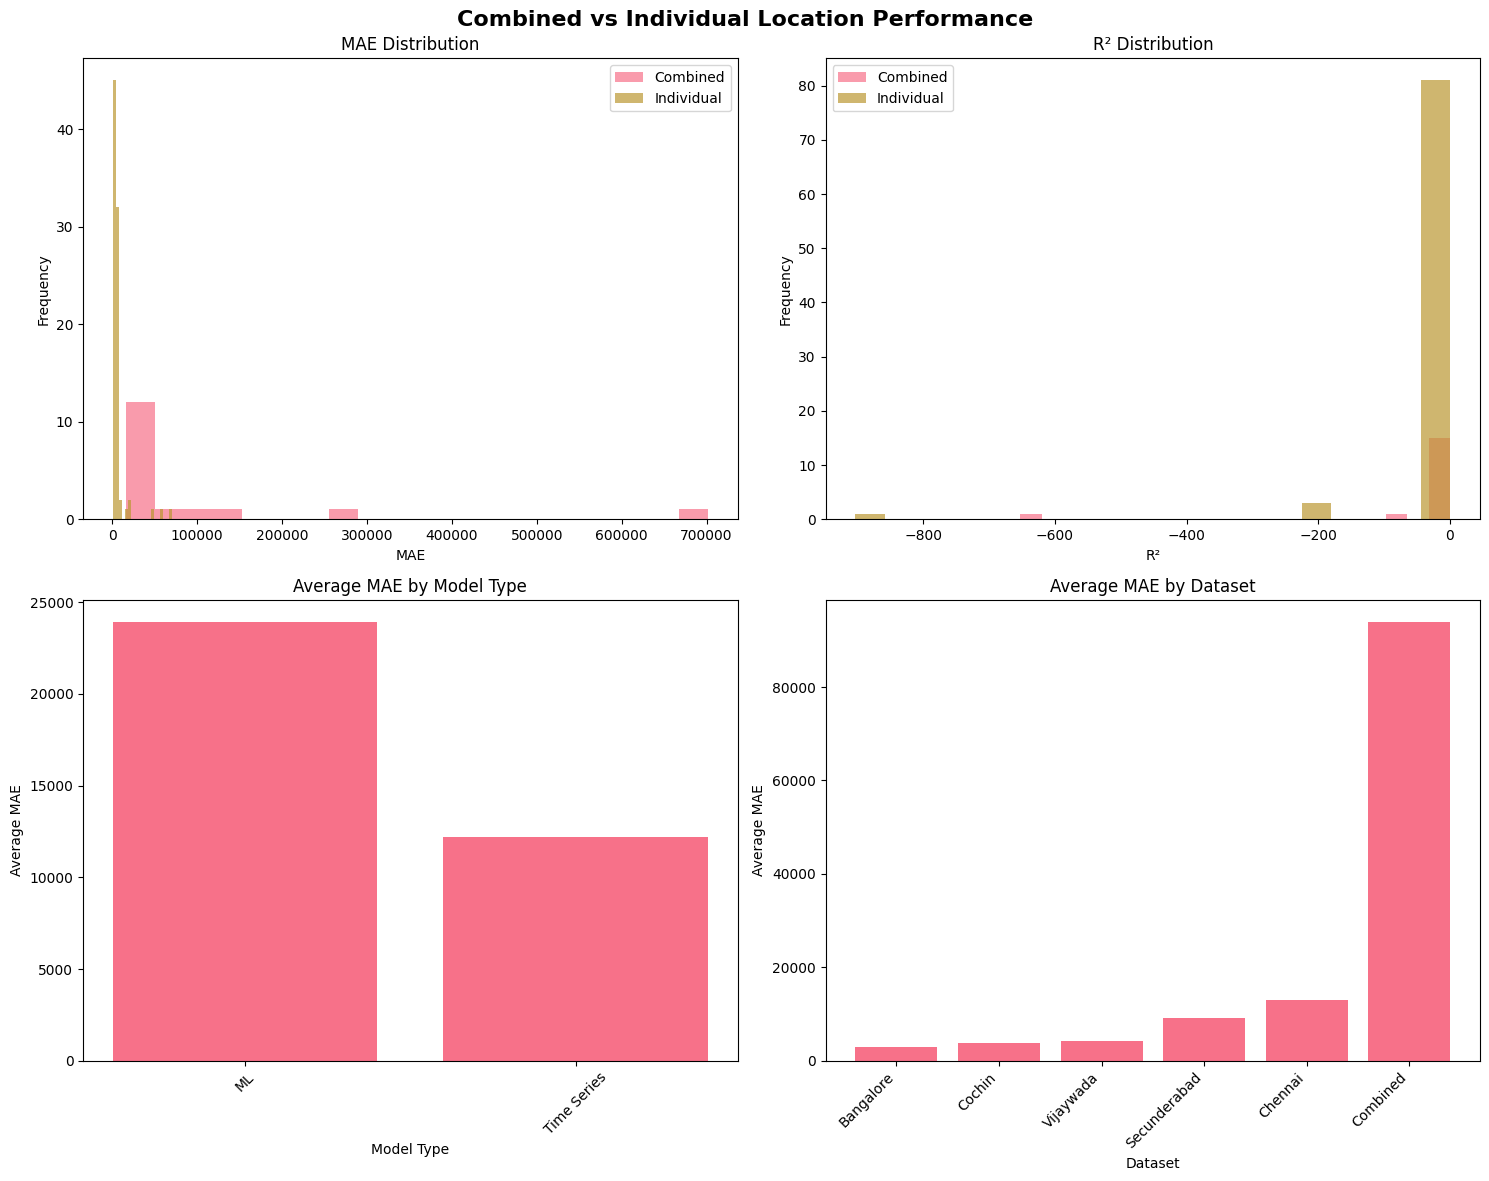

Combined vs Individual performance plot saved!


In [10]:
# Create visualizations
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create output directory for plots
os.makedirs('../outputs/model_results/plots', exist_ok=True)

# 1. Combined vs Individual Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Combined vs Individual Location Performance', fontsize=16, fontweight='bold')

# MAE comparison
combined_mae = results_df[results_df['Dataset'] == 'Combined']['MAE']
individual_mae = results_df[results_df['Dataset'] != 'Combined']['MAE']

axes[0, 0].hist(combined_mae, alpha=0.7, label='Combined', bins=20)
axes[0, 0].hist(individual_mae, alpha=0.7, label='Individual', bins=20)
axes[0, 0].set_title('MAE Distribution')
axes[0, 0].set_xlabel('MAE')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# R² comparison
combined_r2 = results_df[results_df['Dataset'] == 'Combined']['R2']
individual_r2 = results_df[results_df['Dataset'] != 'Combined']['R2']

axes[0, 1].hist(combined_r2, alpha=0.7, label='Combined', bins=20)
axes[0, 1].hist(individual_r2, alpha=0.7, label='Individual', bins=20)
axes[0, 1].set_title('R² Distribution')
axes[0, 1].set_xlabel('R²')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Model type performance
model_type_mae = results_df.groupby('Model_Type')['MAE'].mean()
axes[1, 0].bar(model_type_mae.index, model_type_mae.values)
axes[1, 0].set_title('Average MAE by Model Type')
axes[1, 0].set_xlabel('Model Type')
axes[1, 0].set_ylabel('Average MAE')
axes[1, 0].tick_params(axis='x', rotation=45)

# Dataset performance
dataset_mae = results_df.groupby('Dataset')['MAE'].mean().sort_values()
axes[1, 1].bar(range(len(dataset_mae)), dataset_mae.values)
axes[1, 1].set_title('Average MAE by Dataset')
axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('Average MAE')
axes[1, 1].set_xticks(range(len(dataset_mae)))
axes[1, 1].set_xticklabels(dataset_mae.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../outputs/model_results/plots/combined_vs_individual_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Combined vs Individual performance plot saved!")


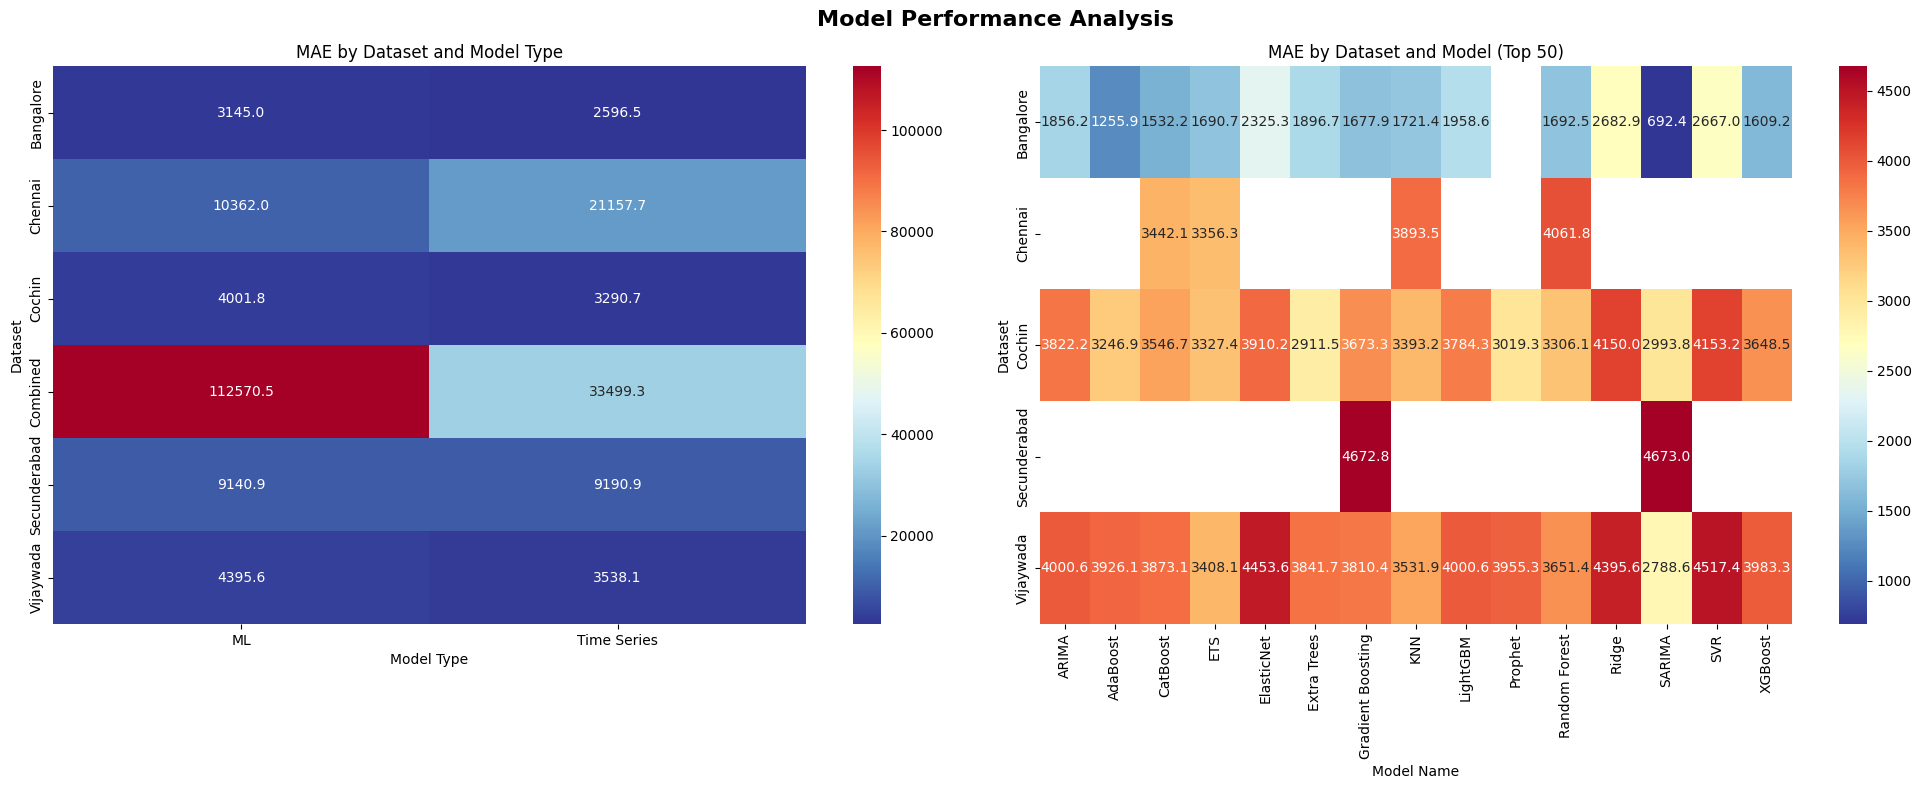

Model performance heatmap saved!


In [11]:
# 2. Model Performance Heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# Model performance by dataset and model type
pivot_mae = results_df.pivot_table(values='MAE', index='Dataset', columns='Model_Type', aggfunc='mean')
sns.heatmap(pivot_mae, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[0])
axes[0].set_title('MAE by Dataset and Model Type')
axes[0].set_xlabel('Model Type')
axes[0].set_ylabel('Dataset')

# Model performance by dataset and model name (top models only)
top_models = results_df.nsmallest(50, 'MAE')  # Top 50 models
pivot_model = top_models.pivot_table(values='MAE', index='Dataset', columns='Model_Name', aggfunc='mean')
sns.heatmap(pivot_model, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[1])
axes[1].set_title('MAE by Dataset and Model (Top 50)')
axes[1].set_xlabel('Model Name')
axes[1].set_ylabel('Dataset')

plt.tight_layout()
plt.savefig('../outputs/model_results/plots/model_performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model performance heatmap saved!")


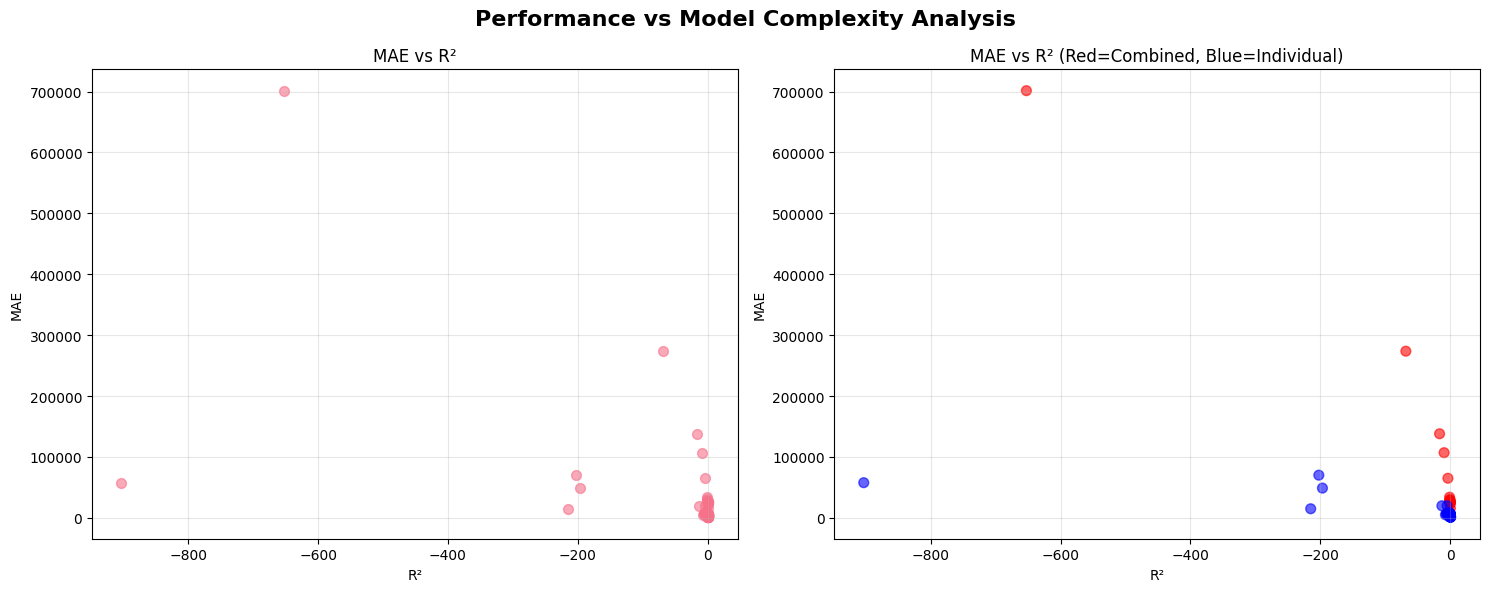

Performance vs complexity analysis plot saved!


In [12]:
# 3. Performance vs Model Complexity Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Performance vs Model Complexity Analysis', fontsize=16, fontweight='bold')

# MAE vs R² scatter plot
axes[0].scatter(results_df['R2'], results_df['MAE'], alpha=0.6, s=50)
axes[0].set_xlabel('R²')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE vs R²')
axes[0].grid(True, alpha=0.3)

# Color by dataset
colors = ['red' if dataset == 'Combined' else 'blue' for dataset in results_df['Dataset']]
axes[1].scatter(results_df['R2'], results_df['MAE'], c=colors, alpha=0.6, s=50)
axes[1].set_xlabel('R²')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE vs R² (Red=Combined, Blue=Individual)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/model_results/plots/performance_vs_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance vs complexity analysis plot saved!")


In [13]:
# Final Summary and Recommendations
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# 1. Overall Performance Summary
print("\n1. OVERALL PERFORMANCE SUMMARY")
print("-" * 50)

# Combined dataset performance
combined_avg_mae = results_df[results_df['Dataset'] == 'Combined']['MAE'].mean()
individual_avg_mae = results_df[results_df['Dataset'] != 'Combined']['MAE'].mean()

print(f"Combined Dataset Average MAE: {combined_avg_mae:.2f}")
print(f"Individual Locations Average MAE: {individual_avg_mae:.2f}")

if combined_avg_mae < individual_avg_mae:
    improvement = ((individual_avg_mae - combined_avg_mae) / individual_avg_mae) * 100
    print(f"Combined dataset performs {improvement:.2f}% better than individual locations")
else:
    degradation = ((combined_avg_mae - individual_avg_mae) / individual_avg_mae) * 100
    print(f"Individual locations perform {degradation:.2f}% better than combined dataset")

# 2. Best Strategy Analysis
print("\n2. BEST STRATEGY ANALYSIS")
print("-" * 50)

# Best model for combined dataset
combined_best = results_df[results_df['Dataset'] == 'Combined'].loc[results_df[results_df['Dataset'] == 'Combined']['MAE'].idxmin()]
print(f"Best Combined Model: {combined_best['Model_Name']} (MAE: {combined_best['MAE']:.2f})")

# Best model for individual locations
individual_best = results_df[results_df['Dataset'] != 'Combined'].loc[results_df[results_df['Dataset'] != 'Combined']['MAE'].idxmin()]
print(f"Best Individual Model: {individual_best['Model_Name']} on {individual_best['Dataset']} (MAE: {individual_best['MAE']:.2f})")

# 3. Model Type Recommendations
print("\n3. MODEL TYPE RECOMMENDATIONS")
print("-" * 50)

# Best model type for combined dataset
combined_by_type = results_df[results_df['Dataset'] == 'Combined'].groupby('Model_Type')['MAE'].mean()
best_combined_type = combined_by_type.idxmin()
print(f"Best Model Type for Combined Dataset: {best_combined_type} (MAE: {combined_by_type[best_combined_type]:.2f})")

# Best model type for individual locations
individual_by_type = results_df[results_df['Dataset'] != 'Combined'].groupby('Model_Type')['MAE'].mean()
best_individual_type = individual_by_type.idxmin()
print(f"Best Model Type for Individual Locations: {best_individual_type} (MAE: {individual_by_type[best_individual_type]:.2f})")

# 4. Location-specific Recommendations
print("\n4. LOCATION-SPECIFIC RECOMMENDATIONS")
print("-" * 50)

for location in results_df[results_df['Dataset'] != 'Combined']['Dataset'].unique():
    loc_results = results_df[results_df['Dataset'] == location]
    best_loc_model = loc_results.loc[loc_results['MAE'].idxmin()]
    print(f"{location}: {best_loc_model['Model_Name']} (MAE: {best_loc_model['MAE']:.2f})")

# 5. Practical Recommendations
print("\n5. PRACTICAL RECOMMENDATIONS")
print("-" * 50)

print("1. For Production Deployment:")
if combined_avg_mae < individual_avg_mae:
    print("   - Use Combined Dataset approach for better overall performance")
    print(f"   - Best model: {combined_best['Model_Name']} (MAE: {combined_best['MAE']:.2f})")
else:
    print("   - Use Individual Location approach for better performance")
    print(f"   - Best model: {individual_best['Model_Name']} on {individual_best['Dataset']} (MAE: {individual_best['MAE']:.2f})")

print("\n2. For Different Scenarios:")
print("   - New locations with limited data: Use Combined Dataset approach")
print("   - Established locations with rich data: Use Individual Location approach")
print("   - Maximum accuracy: Use the best performing individual model per location")

print("\n3. Implementation Strategy:")
print("   - Start with Combined Dataset for baseline")
print("   - Evaluate Individual Location models for specific locations")
print("   - Use ensemble methods to combine both approaches")

print("\n4. Monitoring and Maintenance:")
print("   - Track performance of both approaches over time")
print("   - Implement automated model selection based on performance")
print("   - Use cross-validation for model weight optimization")

print(f"\n{'='*80}")
print("COMBINED LOCATION ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"{'='*80}")



FINAL SUMMARY AND RECOMMENDATIONS

1. OVERALL PERFORMANCE SUMMARY
--------------------------------------------------
Combined Dataset Average MAE: 93965.52
Individual Locations Average MAE: 6619.81
Individual locations perform 1319.46% better than combined dataset

2. BEST STRATEGY ANALYSIS
--------------------------------------------------
Best Combined Model: SARIMA (MAE: 15695.40)
Best Individual Model: SARIMA on Bangalore (MAE: 692.39)

3. MODEL TYPE RECOMMENDATIONS
--------------------------------------------------
Best Model Type for Combined Dataset: Time Series (MAE: 33499.26)
Best Model Type for Individual Locations: ML (MAE: 6209.05)

4. LOCATION-SPECIFIC RECOMMENDATIONS
--------------------------------------------------
Bangalore: SARIMA (MAE: 692.39)
Chennai: ETS (MAE: 3356.30)
Cochin: Extra Trees (MAE: 2911.54)
Secunderabad: Gradient Boosting (MAE: 4672.80)
Vijaywada: SARIMA (MAE: 2788.55)

5. PRACTICAL RECOMMENDATIONS
--------------------------------------------------
1.